# les analyses sur les ventes à découvert (VAD)

## Install pip packages in the current Jupyter kernel

In [1]:
import sys
!{sys.executable} -m pip install matplotlib==3.8.3 pandas==2.2.1 
!{sys.executable} -m pip show matplotlib pandas


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Name: matplotlib
Version: 3.8.3
Summary: Python plotting package
Home-page: https://matplotlib.org
Author: John D. Hunter, Michael Droettboom
Author-email: matplotlib-users@python.org
License: PSF
Location: /Users/ruijinghu/.local/share/virtualenvs/vad_analysis-w4D06N5W/lib/python3.10/site-packages
Requires: contourpy, cycler, fonttools, kiwisolver, numpy, packaging, pillow, pyparsing, python-dateutil
Required-by: 
---
Name: pandas
Version: 2.2.1
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: https://pandas.pydata.org
Author: 
Author-email: The Pandas Development Team <pandas-dev@python.org>
License: BSD 3-Clause License
        
        Copyright (c) 2008-2011, AQR Capital Management, LLC, Lambda Foundry, Inc. and PyData Development Team
        All rights reserved.
        
        Copyright (c) 2011-2023, Open source contributors

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

## Load the CSV file into a DataFrame

In [3]:
report_name  = 'export_od_vad_20240315111500_20240315123000.csv'
df = pd.read_csv(report_name, sep=";")
print(df.columns)

Index(['Detenteur de la position courte nette',
       'Legal Entity Identifier detenteur', 'Emetteur / issuer', 'Ratio',
       'code ISIN', 'Date de debut position',
       'Date de debut de publication position',
       'Date de fin de publication position'],
      dtype='object')


In [4]:
class Flds:
    HOLDER: str = 'Detenteur de la position courte nette'
    LEID: str = 'Legal Entity Identifier detenteur'
    ISSU: str = 'Emetteur / issuer'
    RAT: str = 'Ratio'
    ISIN: str = 'code ISIN'
    POS_DAT: str = 'Date de debut position'
    PUB_BEG_DAT: str = 'Date de debut de publication position'
    PUB_END_DAT: str = 'Date de fin de publication position'
    
    # new
    DURATION: str = 'Duration'

In [5]:
# dates converstion
for col in [Flds.POS_DAT, Flds.PUB_BEG_DAT, Flds.PUB_END_DAT]:
    df[col] = pd.to_datetime(df[col], format='%Y-%m-%d')
# floats conversion
for col in [Flds.RAT]:
    df[col] = df[col].astype(float)
print(df.dtypes)

Detenteur de la position courte nette            object
Legal Entity Identifier detenteur                object
Emetteur / issuer                                object
Ratio                                           float64
code ISIN                                        object
Date de debut position                   datetime64[ns]
Date de debut de publication position    datetime64[ns]
Date de fin de publication position      datetime64[ns]
dtype: object


## Analysis

### How many short position holders are listed in the dataframe?

In [6]:
num_short_position_holders = df[Flds.HOLDER].nunique()
print("Number of short position holders:", num_short_position_holders)

Number of short position holders: 346


### Who are the top 5 holders with the largest total sum of open short positions?

In [7]:
# supposing that total shares outstanding of every issuer is the same, since the entry source does not give the enough information
top_5_holders = df.groupby(Flds.HOLDER)[Flds.RAT].sum().nlargest(5)
print("Top 5 holders with largest total sum of open short positions:")
print(top_5_holders)

Top 5 holders with largest total sum of open short positions:
Detenteur de la position courte nette
MARSHALL WACE LLP                               5876.52
AQR CAPITAL MANAGEMENT, LLC                     2391.57
CITADEL EUROPE LLP                              1289.52
CITADEL ADVISORS LLC                            1186.14
BLACKROCK INVESTMENT MANAGEMENT (UK) LIMITED    1128.45
Name: Ratio, dtype: float64


### Which are the top 5 issuers with the highest median ratios?

In [8]:
top_5_issuers = df.groupby(Flds.ISSU)[Flds.RAT].median().nlargest(5)
print("Top 5 issuers with highest median ratios:")
print(top_5_issuers)

Top 5 issuers with highest median ratios:
Emetteur / issuer
PIERRE ET VACANCES           1.645
MEDIAWAN                     1.480
GAZTRANSPORT ET TECHNIGAZ    1.240
EOS IMAGING                  1.110
INGENICO GROUP               1.030
Name: Ratio, dtype: float64


### What is the maximum number of days that a short position can be held? Which issuer is involved? Who is dedicating this position? Ditto for the shortest duration.

In [9]:
df[Flds.DURATION] = df[Flds.PUB_END_DAT] - df[Flds.PUB_BEG_DAT]
max_duration = df[Flds.DURATION].max()
min_duration = df[Flds.DURATION].min()
max_duration_info = df[df[Flds.DURATION] == max_duration]
min_duration_info = df[df[Flds.DURATION] == min_duration]
print("Maximum duration of short position:", max_duration)
print("Issuer involved in maximum duration:", '|'.join(max_duration_info[Flds.ISSU].unique()))
print("Holder dedicating the position for maximum duration:", '|'.join(max_duration_info[Flds.HOLDER].unique()))
print("Minimum duration of short position:", min_duration)
print("Issuer involved in minimum duration:", '|'.join(min_duration_info[Flds.ISSU].unique()))
print("Holder dedicating the position for minimum duration:", '|'.join(min_duration_info[Flds.HOLDER].unique()))

Maximum duration of short position: 2576 days 00:00:00
Issuer involved in maximum duration: REMY COINTREAU
Holder dedicating the position for maximum duration: AQR CAPITAL MANAGEMENT, LLC
Minimum duration of short position: -59 days +00:00:00
Issuer involved in minimum duration: AIR FRANCE-KLM
Holder dedicating the position for minimum duration: LONE PINE CAPITAL LLC


In [10]:
df[df[Flds.DURATION].isin([min_duration, max_duration])]

,Detenteur de la position courte nette,Legal Entity Identifier detenteur,Emetteur / issuer,Ratio,code ISIN,Date de debut position,Date de debut de publication position,Date de fin de publication position,Duration
2141,"AQR CAPITAL MANAGEMENT, LLC",549300GC5MDF1KXYMP06,REMY COINTREAU,0.50,FR0000130395,2014-01-29,2014-01-30,2021-02-18,2576 days
14983,LONE PINE CAPITAL LLC,Y64HK18CMXIV6KGY3S63,AIR FRANCE-KLM,0.79,FR0000031122,2012-10-31,2013-01-04,2012-11-06,-59 days


#### It is anormal to have negative duration for a position. I analyze two cases

#### I analyze the non negative duration:

In [11]:
df_b = df.copy()
df_b = df_b.loc[df_b[Flds.DURATION].dt.total_seconds()>=0]
max_duration = df_b[Flds.DURATION].max()
min_duration = df_b[Flds.DURATION].min()
max_duration_info = df_b[df_b[Flds.DURATION] == max_duration]
min_duration_info = df_b[df_b[Flds.DURATION] == min_duration]
print("Maximum duration of short position:", max_duration)
print("Issuer involved in maximum duration:", '|'.join(max_duration_info[Flds.ISSU].unique()))
print("Holder dedicating the position for maximum duration:", '|'.join(max_duration_info[Flds.HOLDER].unique()))
print("Minimum duration of short position:", min_duration)
print("Issuer involved in minimum duration:", '|'.join(min_duration_info[Flds.ISSU].unique()))
print("Holder dedicating the position for minimum duration:", '|'.join(min_duration_info[Flds.HOLDER].unique()))

Maximum duration of short position: 2576 days 00:00:00
Issuer involved in maximum duration: REMY COINTREAU
Holder dedicating the position for maximum duration: AQR CAPITAL MANAGEMENT, LLC
Minimum duration of short position: 0 days 00:00:00
Issuer involved in minimum duration: EUROFINS SCIENTIFIC SE|CGG|JCDECAUX SE|VALLOUREC
Holder dedicating the position for minimum duration: Coltrane Master Fund, L.P.|MARSHALL WACE LLP|NAYA CAPITAL MANAGEMENT UK LIMITED|WORLDQUANT, LLC


#### I analyze if defining DURATION = Date de fin de publication position - Date de debut position

In [12]:
df_a = df.copy()
df_a[Flds.DURATION] = df_a[Flds.PUB_END_DAT] - df_a[Flds.POS_DAT]
max_duration = df_a[Flds.DURATION].max()
min_duration = df_a[Flds.DURATION].min()
max_duration_info = df_a[df_a[Flds.DURATION] == max_duration]
min_duration_info = df_a[df_a[Flds.DURATION] == min_duration]
print("Maximum duration of short position:", max_duration)
print("Issuer involved in maximum duration:", '|'.join(max_duration_info[Flds.ISSU].unique()))
print("Holder dedicating the position for maximum duration:", '|'.join(max_duration_info[Flds.HOLDER].unique()))
print("Minimum duration of short position:", min_duration)
print("Issuer involved in minimum duration:", '|'.join(min_duration_info[Flds.ISSU].unique()))
print("Holder dedicating the position for minimum duration:", '|'.join(min_duration_info[Flds.HOLDER].unique()))

Maximum duration of short position: 2577 days 00:00:00
Issuer involved in maximum duration: REMY COINTREAU
Holder dedicating the position for maximum duration: AQR CAPITAL MANAGEMENT, LLC
Minimum duration of short position: 1 days 00:00:00
Issuer involved in minimum duration: ARKEMA|CASINO GUICHARD-PERRACHON|REXEL|SCOR SE|VALEO|VALLOUREC|SOLOCAL GROUP|DASSAULT SYSTEMES|GEMALTO NV|ETABLISSEMENTS MAUREL ET PROM|CGG|SOITEC|PEUGEOT S.A.|UBISOFT ENTERTAINMENT
Holder dedicating the position for minimum duration: CITADEL EUROPE LLP|GLG Partners LP|GUEVOURA FUND LIMITED|HIGHFIELDS CAPITAL MANAGEMENT LP|HOPLITE CAPITAL MANAGEMENT, L.P.|LEDBURY CAPITAL PARTNERS LLP|Magnolia Road Capital LP|Numeric Investors LLC|PENTWATER CAPITAL MANAGEMENT LP|SCGE MANAGEMENT, L.P.


### Show the histogram of ratios associated with AIR FRANCE-KLM.

In [13]:
df_afk = df[df[Flds.ISSU] == 'AIR FRANCE-KLM']
print(df_afk[Flds.RAT].info())

<class 'pandas.core.series.Series'>
Index: 1939 entries, 164 to 30095
Series name: Ratio
Non-Null Count  Dtype  
--------------  -----  
1939 non-null   float64
dtypes: float64(1)
memory usage: 30.3 KB
None


In [14]:
print(df_afk[Flds.RAT].describe())

count    1939.000000
mean        1.163811
std         0.720282
min         0.000000
25%         0.610000
50%         0.910000
75%         1.530000
max         3.840000
Name: Ratio, dtype: float64


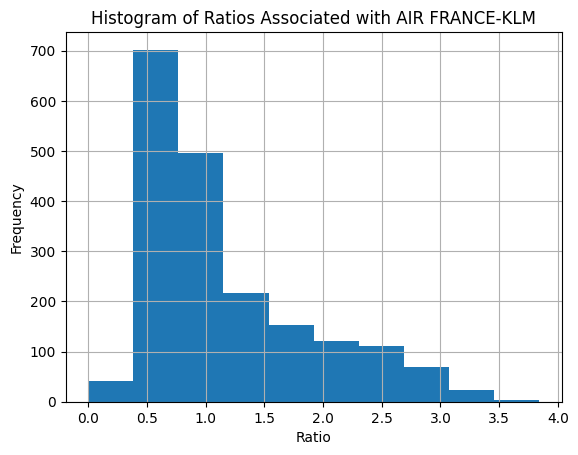

In [15]:
df_afk[Flds.RAT].hist()
plt.title('Histogram of Ratios Associated with AIR FRANCE-KLM')
plt.xlabel('Ratio')
plt.ylabel('Frequency')
plt.show()

### analysis

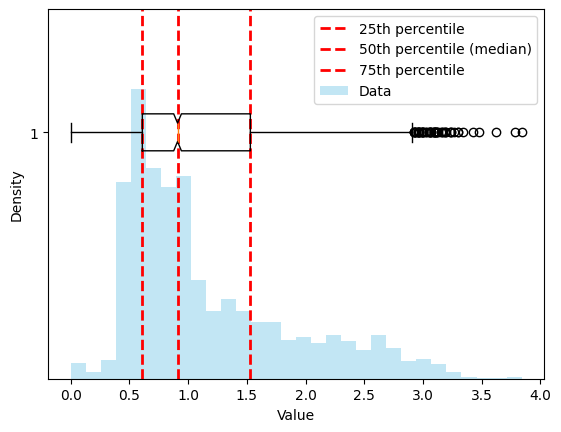

In [16]:
import numpy as np
# Filter rows associated with AIR FRANCE-KLM
air_france_klm_df = df[df[Flds.ISSU] == 'AIR FRANCE-KLM']
data = air_france_klm_df['Ratio']
# Compute quantiles
quantiles = np.percentile(data, [25, 50, 75])

# Plot histogram
plt.hist(data, bins=30, density=True, alpha=0.5, color='skyblue')

# Plot quantiles as vertical lines
for q in quantiles:
    plt.axvline(q, color='red', linestyle='--', linewidth=2)

# Add legend and labels
plt.legend(['25th percentile', '50th percentile (median)', '75th percentile', 'Data'])
plt.xlabel('Value')
plt.ylabel('Density')

# box plot
plt.boxplot(data, vert=False, notch=True)
# Show plot
plt.show()